<img src="https://www.bu.edu/files/2022/07/feat-crop-iStock-1026002288.jpg" width=70%/>


**Alzheimer's disease** is a condition where neurons within the brain stop functioning, lose connection with other neurons and die. It's the most common cause of dementia, a loss of brain function that can adversely impact memory, thinking, language, judgment and behavior. Alzheimer's is irreversible and progressive.

Alzheimer's is evaluated by identifying certain symptoms and ruling out other possible causes of dementia. Your doctor will likely perform a complete medical exam, including neurological, blood and brain imaging exams, such as CT, MRI or PET/CT of the head. There is no cure for Alzheimer's disease. However, your doctor may prescribe medication to slow the disease's progression and manage your symptoms.

**MRI of the head**: Magnetic resonance imaging (MRI) uses a powerful magnetic field, radio frequency pulses and a computer to produce detailed pictures of organs, soft tissues, bone and virtually all other internal body structures. MRI can detect brain abnormalities associated with mild cognitive impairment (MCI) and can be used to predict which patients with MCI may eventually develop Alzheimer's disease. In the early stages of Alzheimer's disease, an MRI scan of the brain may be normal. In later stages, MRI may show a decrease in the size of different areas of the brain (mainly affecting the temporal and parietal lobes).

## In this NoteBook

**In this NoteBook**, a convolutional neural network (CNN)-based Alzheimer MRI images classification algorithm is developed using ResNet152V2 architecture, to detect "Mild Demented", "Moderate Demented", "Non Demented" and "Very Mild Demented" in patient's MRI.

# 1. Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import applications
from PIL import Image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
    
from helper_functions import plot_loss_curves

--2022-11-15 12:21:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-15 12:21:59 (35.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 2. Uploading the Data

In [3]:
SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

data_dir = '../input/augmented-alzheimer-mri-dataset-v2/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# 3. Defining Categories

In [4]:
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

### Calculating the number of images in each category in training data

In [5]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

MildDemented 8960 images
ModerateDemented 6464 images
NonDemented 9600 images
VeryMildDemented 8960 images


# 4. Creating Train and Validation DataFrame

In [6]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(33984, 3)

In [7]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=4)

In [9]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [10]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(27187, 3)
(6797, 3)


In [11]:
train.head()

file          category  \
0  train/NonDemented/7e38382f-8007-4a5c-955b-b3ba...       NonDemented   
1  train/MildDemented/75ae5bb9-20b5-4469-be39-f60...      MildDemented   
2  train/VeryMildDemented/b77c0cb3-cc75-4626-a73d...  VeryMildDemented   
3  train/ModerateDemented/c1916c48-ecc7-4a50-975e...  ModerateDemented   
4  train/VeryMildDemented/1e24e08d-c593-4e1f-be40...  VeryMildDemented   

   category_id  
0            2  
1            0  
2            3  
3            1  
4            3

In [12]:
validation.head()

file      category  \
0  train/MildDemented/4c1e75ef-254e-43d2-8290-ebe...  MildDemented   
1  train/NonDemented/e94849b3-ff51-4481-82cb-0337...   NonDemented   
2  train/MildDemented/d6f9eab8-1129-41f0-9b68-25f...  MildDemented   
3  train/NonDemented/cc1aa6a4-b6b2-40e5-a42a-7418...   NonDemented   
4  train/MildDemented/0e422cb4-6bac-4830-b963-67e...  MildDemented   

   category_id  
0            0  
1            2  
2            0  
3            2  
4            0

# 5. Creating Test DataFrame

In [13]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape

(6400, 3)

# 6. Demonstrating Example Images

In [14]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

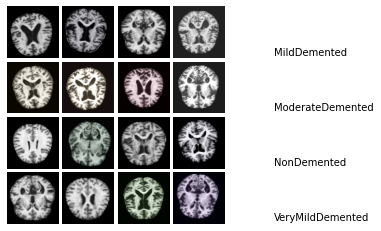

In [15]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0    
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1
        
plt.show();

# 7. Keras ImageDataGenerator

In [16]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="../input/augmented-alzheimer-mri-dataset-v2/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

validation_generator = datagen_train.flow_from_dataframe(dataframe=validation,
                                                  directory="../input/augmented-alzheimer-mri-dataset-v2/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 27187 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [17]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                  directory="../input/augmented-alzheimer-mri-dataset-v2/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 6400 validated image filenames belonging to 4 classes.


# 8. Early Stopping

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# 9. Creating Model based on ResNet152V2

In [19]:
def create_model():
   
    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )
    
    for layers in resnet_model.layers[:100]:
        layers.trainable = False
    for layers in resnet_model.layers[100:]:
        layers.trainable = True

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return res_model

In [20]:
res_model = create_model()

2022-11-15 12:24:22.456504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:24:22.544418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:24:22.545239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:24:22.547034: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

234561536/234545216 [==============================] - 1s 0us/step


In [21]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

### Plotting the Model

In [22]:
plot_model(res_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

# 10. Training the Model

In [23]:
history = res_model.fit(train_generator,
                    epochs=500, 
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    batch_size=32)

2022-11-15 12:24:40.938742: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-11-15 12:24:55.050008: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 102s 827ms/step - loss: 1.1093 - accuracy: 0.4769 - val_loss: 70.4345 - val_accuracy: 0.1898
Epoch 2/500
100/100 [==============================] - 44s 439ms/step - loss: 0.8552 - accuracy: 0.6125 - val_loss: 743.3960 - val_accuracy: 0.2170
Epoch 3/500
100/100 [==============================] - 37s 373ms/step - loss: 0.7965 - accuracy: 0.6313 - val_loss: 46.3708 - val_accuracy: 0.1938
Epoch 4/500
100/100 [==============================] - 37s 365ms/step - loss: 0.7002 - accuracy: 0.6856 - val_loss: 1.6232 - val_accuracy: 0.5758
Epoch 5/500
100/100 [==============================] - 33s 326ms/step - loss: 0.7446 - accuracy: 0.7016 - val_loss: 321.6063 - val_accuracy: 0.1996
Epoch 6/500
100/100 [==============================] - 31s 314ms/step - loss: 0.6357 - accuracy: 0.7272 - val_loss: 1.0278 - val_accuracy: 0.6434
Epoch 7/500
100/100 [==============================] - 31s 311ms/step - loss: 0.5667 - accuracy: 0.7369 - val_loss: 0.8479 - val_

### Plotting the history of model

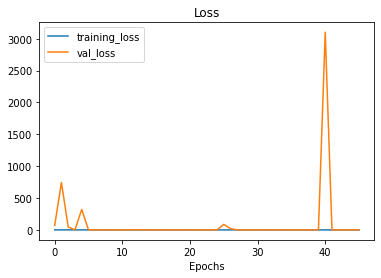

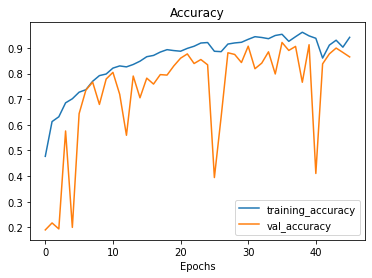

In [24]:
plot_loss_curves(history)

# 10. Evaluation

In [25]:
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

213/213 [==============================] - 16s 76ms/step - loss: 0.4519 - accuracy: 0.8648

Train loss: 0.45
Train Accuracy: 86.48 %


In [26]:
loss, accuracy = res_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

200/200 [==============================] - 61s 305ms/step - loss: 0.3888 - accuracy: 0.8836

Test loss: 0.39 
Test Accuracy: 88.36 %


In [27]:
y_predict = res_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
MildDemented       0.980285  0.998884  0.989497   896.000000
ModerateDemented   0.955224  1.000000  0.977099    64.000000
NonDemented        0.998383  0.771875  0.870638  3200.000000
VeryMildDemented   0.755601  0.993750  0.858465  2240.000000
accuracy           0.883594  0.883594  0.883594     0.883594
macro avg          0.922373  0.941127  0.923925  6400.000000
weighted avg       0.910444  0.883594  0.884082  6400.000000